# 05. Deep Learning: GRU Model

This notebook trains a Gated Recurrent Unit (GRU) neural network using PyTorch. It handles the sequential nature of the data/features.

In [1]:
# Imports
import pandas as pd
import numpy as np
import pickle
import json
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, 
    precision_recall_curve, auc, brier_score_loss
)

import warnings
warnings.filterwarnings("ignore")

# Settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Processed Data

In [2]:
# Load data
with open('../data/processed/churn_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train_scaled'] 
y_train = data['y_train']
X_val = data['X_val_scaled']
y_val = data['y_val']
X_test = data['X_test_scaled']
y_test = data['y_test']

print(f"Train samples: {len(X_train)}")
print(f"Val samples:   {len(X_val)}")

Train samples: 265
Val samples:   67


## 2. Prepare Data for PyTorch

Reshape input from (N, Features) to (N, 1, Features) since we treat it as a sequence of length 1 (aggregated trial).

In [3]:
class ChurnDataset(Dataset):
    def __init__(self, X, y):
        # Reshape to (Batch, Sequence, Features)
        self.X = torch.FloatTensor(X.values if hasattr(X, 'values') else X).unsqueeze(1)
        self.y = torch.FloatTensor(y.values if hasattr(y, 'values') else y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(ChurnDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ChurnDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(ChurnDataset(X_test, y_test), batch_size=batch_size)

input_size = X_train.shape[1]
print(f"Input features: {input_size}")

Input features: 154


## 3. Define GRU Model

In [4]:
class GRUChurnModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRUChurnModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, 
            batch_first=True, dropout=dropout
        )
        
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)
        # Removed self.sigmoid for BCEWithLogitsLoss
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        
        # Take last time step
        out = out[:, -1, :]
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze() # Return logits


## 4. Train Model

In [5]:
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim

model = GRUChurnModel(
    input_size=input_size,
    hidden_size=256,
    num_layers=2, 
    dropout=0.01
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
epochs = 200 # Reduced epochs
best_val_loss = float('inf')
patience = 20
counter = 0

train_losses = []
val_losses = []

print("Starting training...")
# Progress bar for epochs
for epoch in tqdm(range(epochs), desc="Training"):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if (epoch+1) % 10 == 0:
        # Use tqdm.write instead of print to keep bar intact
        tqdm.write(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
        
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../results/models/gru/gru_best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            tqdm.write(f"Early stopping at epoch {epoch+1}")
            break

print(" Training complete")


Starting training...


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10/200 - Train Loss: 0.5215 - Val Loss: 0.6084
Epoch 20/200 - Train Loss: 0.3804 - Val Loss: 0.6249
Early stopping at epoch 26
 Training complete


 Saved training loss plot


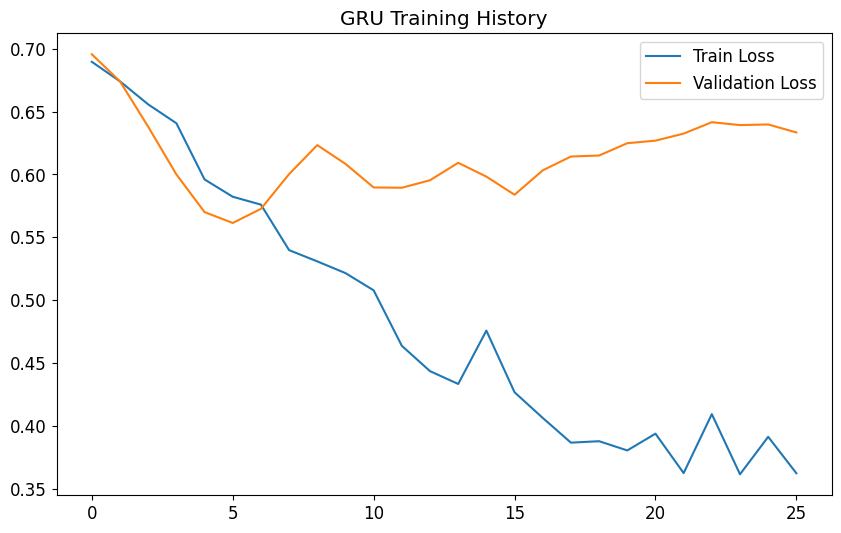

In [6]:
# Plot Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("GRU Training History")

plt.savefig('../results/figures/gru/gru_training_loss.png')
print(' Saved training loss plot')
plt.show()

## 5. Evaluation

In [7]:
# Load Best Model
model.load_state_dict(torch.load('../results/models/gru/gru_best_model.pt'))
model.eval()

y_true = []
y_pred_proba = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        # Apply sigmoid to logits for probabilities
        y_pred_proba.extend(torch.sigmoid(outputs).cpu().numpy())
        
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
pr_auc = auc(recall, precision)

brier = brier_score_loss(y_true, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Brier Score: {brier:.4f}")


Accuracy: 0.7470
ROC-AUC: 0.7430
PR-AUC: 0.7624
Brier Score: 0.2155


## 6. Save Results

In [8]:
# Save Metrics
metrics = {
    'model': 'LSTM/GRU',
    'accuracy': float(accuracy),
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc),
    'brier': float(brier)
}

with open('../results/metrics/gru/gru_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
print(" Metrics saved to ../results/metrics/gru/gru_metrics.json")

 Metrics saved to ../results/metrics/gru/gru_metrics.json


In [9]:
#